In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
%matplotlib inline

import lightgbm as lgb
import gc
import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # 初期状態のメモリ消費量確認 （=value.nbytes)
    start_mem = df.memory_usage().sum() / 1024**2    
    
    # 各列について
    for col in df.columns:
        col_type = df[col].dtypes
        # 列のタイプがint16~64 or float16~64なら
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            # int型なら
            if str(col_type)[:3] == 'int':
                # 列の全値がint8型の範囲に収まるなら列の値をint8型に変換
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                # 列の全値がint16型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                # 列の全値がint32型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                # 列の全値がint64型の範囲に収まるなら...
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # float型なら
            else:
                # 列の全値がfloat32型の範囲に収まるなら列の値をfloat32型に変換
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                # 列の値をfloat64型に
                else:
                    df[col] = df[col].astype(np.float64)
    # 型変換の後のメモリ消費量を確認
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
folder_path = './ieee-fraud-detection'
train_identity = pd.read_csv(f'{folder_path}/train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}/train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}/test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}/test_transaction.csv')
sample_sub = pd.read_csv(f'{folder_path}/sample_submission.csv')

tr = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
te = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
tr.shape

(590540, 434)

In [7]:
train = tr.copy()
test = te.copy()

In [8]:
base_columns = list(train)

# Add feature

In [9]:
seed = 35

In [10]:
def encode_trigonometric(df, cols):
    for col in cols:
        df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
        df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [11]:
m_cols = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

In [12]:
import datetime
start_date = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [13]:
def add_feature(df):
    df['TransactionAmt_mean_diff'] = df['TransactionAmt'] - df['TransactionAmt'].mean()
    df['TransactionAmt_std_normalize'] = df['TransactionAmt'] / df['TransactionAmt'].std()
    
    df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
    df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')
    
    df['TransactionAmt_decimal'] = ((df['TransactionAmt'] - df['TransactionAmt'].astype(int)) * 1000).astype(int)
    
    # df['TransactionAmt'] = np.log(df['TransactionAmt'])
    
    df['card1_count_full'] = df['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
    
    df['uid'] = df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid2'] = df['uid'].astype(str) + '_' + df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['uid3'] = df['uid2'].astype(str) ; '_' + df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    
    df['id_02_to_mean_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('mean')
    df['id_02_to_mean_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('mean')
    df['id_02_to_std_card1'] = df['id_02'] / df.groupby(['card1'])['id_02'].transform('std')
    df['id_02_to_std_card4'] = df['id_02'] / df.groupby(['card4'])['id_02'].transform('std')
    
    df['D15_to_mean_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('mean')
    df['D15_to_mean_card4'] = df['D15'] / df.groupby(['card4'])['D15'].transform('mean')
    df['D15_to_std_card1'] = df['D15'] / df.groupby(['card1'])['D15'].transform('std')
    df['D15_to_std_card4'] = df['D15'] / df.groupby(['card4'])['D15'].transform('std')
    
    df['D15_to_mean_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('mean')
    df['D15_to_mean_addr2'] = df['D15'] / df.groupby(['addr2'])['D15'].transform('mean')
    df['D15_to_std_addr1'] = df['D15'] / df.groupby(['addr1'])['D15'].transform('std')
    df['D15_to_std_addr2'] = df['D15'] / df.groupby(['addr2'])['D15'].transform('std')
    
    # df['M_sum'] = df[m_cols].sum(axis=1).astype(np.int8)
    # df['M_na'] = df[m_cols].isna().sum(axis=1).astype(np.int8)
    
    uknown = 'email_not_provided'
    df['P_emaildomain'] = df['P_emaildomain'].fillna(uknown)
    df['R_emaildomain'] = df['R_emaildomain'].fillna(uknown)
    df['email_check'] = np.where((df['P_emaildomain'] == df['R_emaildomain']) & (df['P_emaildomain'] != uknown), 1, 0)
    df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)
    df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = df['R_emaildomain'].str.split('.', expand=True)
    
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ' '.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ' '.join([i for i in x if i.isnumeric()]))
    
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ' '.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ' '.join([i for i in x if i.isnumeric()]))
    
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ' '.join([i for i in x if i.isalpha()]))
    
    #df['weekdays'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
    #df['hours'] = np.floor(df['TransactionDT'] / 3600) % 24
    
    df['DT'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))
    df['DT_M'] = (df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    df['D9'] = np.where(df['D9'].isna(), 0, 1)
    
    trigonometric_cols = ['DT_hour', 'DT_day_week', 'DT_day']
    df = encode_trigonometric(df, trigonometric_cols)

In [14]:
add_feature(train)
add_feature(test)

In [15]:
train = train.drop('DT', axis=1)
test = test.drop('DT', axis=1)

In [16]:
valid_card = pd.concat([train[['card1']], test[['card1']]])
valid_card = valid_card['card1'].value_counts()
valid_card = valid_card[valid_card > 2]
valid_card = list(valid_card.index)

train['card1'] = np.where(train['card1'].isin(test['card1']), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(train['card1']), test['card1'], np.nan)

train['card1'] = np.where(train['card1'].isin(valid_card), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(valid_card), test['card1'], np.nan)

In [17]:
i_cols = ['card1', 'card2', 'card3', 'card5', 'uid', 'uid2', 'uid3']
for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col + '_TransactionAmt_' + agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col, 'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name] = test[col].map(temp_df)
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [18]:
ii_cols = ['card1', 'card2', 'card3', 'card5',
           'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
          'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'addr1', 'addr2', 'dist1', 'dist2',
          'P_emaildomain', 'R_emaildomain',
           'DeviceInfo', 'id_30', 'id_33', 'uid'
           , 'DeviceInfo_device', 'DeviceInfo_version', 'id_30_device', 'id_30_version', 'id_31_device'
           , 'uid2', 'uid3'
          ]

for col in ii_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
    train[col + '_fq_enc'] = train[col].map(fq_encode)
    test[col + '_fq_enc'] = test[col].map(fq_encode)
    
for col in ['DT_M', 'DT_W', 'DT_D']:
    temp_df = pd.concat([train[[col]], test[col]])
    fq_encode = temp_df[col].value_counts().to_dict()
    train[col + '_total'] = train[col].map(fq_encode)
    test[col + '_total'] = test[col].map(fq_encode)

In [19]:
periods = ['DT_M', 'DT_W', 'DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
        temp_df = pd.concat([train[[col, period]], test[[col, period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
        
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column] = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period + '_total']
        test[new_column] /= test[period + '_total']

In [20]:
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain',
                'P_emaildomain__C2', 'card2__dist1', 'card1__card5', 'card2__id_20',
                'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

for feature in ['id_34', 'id_36']:
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
        
for feature in ['id_01', 'id_31', 'id_33', 'id_35', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

## (Add PCA feature)

In [59]:
def PCA_change(df, cols, n_components, prefix='PCA_', random_seed=10):
    pca = PCA(n_components=n_components, random_state=random_seed)
    principalComponents = pca.fit_transform(df[cols])
    principalDf = pd.DataFrame(principalComponents)
    df.drop(cols, axis=1, inplace=True)
    principalDf.rename(columns=lambda x: str(prefix) + str(x), inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    return df

In [67]:
test['isFraud'] = 'test'
df_all = pd.concat([train, test], axis=0, sort=False)
df_all = df_all.reset_index()
df_all = df_all.drop('index', axis=1)

In [64]:
mas_v = train.columns[55:394]

In [68]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

for col in mas_v:
    df_all[col] = df_all[col].fillna((df_all[col].min() - 2))
    df_all[col] = (minmax_scale(df_all[col], feature_range=(0, 1)))
    
df_all = PCA_change(df_all, mas_v, prefix='PCA_V_', n_components=30, random_seed=seed)

In [69]:
df_all = reduce_mem_usage(df_all)

Mem. usage decreased to 797.36 Mb (36.1% reduction)


In [88]:
train, test = df_all[df_all['isFraud'] != 'test'], df_all[df_all['isFraud'] == 'test'].drop('isFraud', axis=1)

# Preprocessing

In [21]:
def col_drop(df):
    # null or not null で特徴になる？
    null_cols = [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
    big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
    return null_cols, big_top_value_cols, one_value_cols

In [22]:
null_cols_train, big_top_value_cols_train, one_value_cols_train = col_drop(train)
null_cols_test, big_top_value_cols_test, one_value_cols_test = col_drop(test)

cols_to_drop = list(set(null_cols_train + null_cols_test + big_top_value_cols_train + big_top_value_cols_test + one_value_cols_train + one_value_cols_test))
cols_to_drop.remove('isFraud')
len(cols_to_drop)

95

In [23]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

# LabelEncoding

In [24]:
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

# Define X, y for modeling

In [25]:
rm_cols = ['isFraud', 'DT_M', 'DT_W', 'DT_D', 'DT_hour', 'DT_day_week', 'DT_day',
          'DT_D_total', 'DT_W_total', 'DT_M_total', 'id_30', 'id_31', 'id_33']

In [26]:
from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(train)).difference(base_columns + rm_cols)
for i in columns_to_check:
    features_check.append(ks_2samp(test[i], train[i])[1])
    
features_check = pd.Series(features_check, index=columns_to_check).sort_values()
features_discard = list(features_check[features_check==0].index)
print(features_discard)

# features_discard = []

features_columns = [col for col in list(train) if col not in rm_cols + features_discard]

['id_01_count_dist', 'D4_fq_enc', 'id_31_count_dist', 'TransactionAmt_to_std_card4', 'id_35_count_dist', 'D11__DeviceInfo', 'TransactionAmt_std_normalize', 'TransactionAmt_mean_diff', 'id_31_device', 'D15_to_mean_addr1', 'D15_to_std_card4', 'D5_fq_enc', 'D15_to_std_card1', 'D15_to_std_addr1', 'D6_fq_enc', 'D3_fq_enc', 'D15_to_mean_addr2', 'id_33_count_dist', 'D15_to_std_addr2', 'C12_fq_enc', 'id_36_count_dist', 'D15_to_mean_card1', 'D15_to_mean_card4', 'TransactionAmt_to_mean_card4']


In [27]:
test = test[features_columns]
features_columns.append('isFraud')
train = train[features_columns]

In [28]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud'].astype(bool)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
del train
test = test[['TransactionDT', 'TransactionID']]

In [29]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)

X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test)

# resampling

In [35]:
from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold, NearMiss
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE, SVMSMOTE, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
positive_count = y.sum()

def resampling(x, y, method='random', ratio=.10, random_state=None):
    # random
    if method == 'random':
        rus = RandomUnderSampler(sampling_strategy=ratio / 2., random_state=random_state)
        # rus = RandomUnderSampler(ratio={0:positive_count * ratio * 2., 1:positive_count}, random_state=random_state)
        x_under, y_under = rus.fit_sample(x, y)
        smote = SMOTE(sampling_strategy=ratio, random_state=random_state)
        # smote = SMOTE(ratio={0:x_under.shape[0], 1:x_under.shape[0] // ratio}, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'random_adasyn':
        rus = RandomUnderSampler(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = rus.fit_sample(x, y)
        smote = ADASYN(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'random_kmeans':
        rus = RandomUnderSampler(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = rus.fit_sample(x, y)
        smote = KMeansSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'random_svm':
        rus = RandomUnderSampler(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = rus.fit_sample(x, y)
        smote = SVMSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'random_border':
        rus = RandomUnderSampler(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = rus.fit_sample(x, y)
        smote = BorderlineSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)

    # instance
    elif method == 'instance':
        iht = InstanceHardnessThreshold(sampling_strategy=ratio / 2., random_state=random_state)
        # iht = InstanceHardnessThreshold(ratio={0:positive_count * ratio * 2., 1:positive_count}, random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = SMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'instance_adasyn':
        iht = InstanceHardnessThreshold(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = ADASYN(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'instance_kmeans':
        iht = InstanceHardnessThreshold(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = KMeansSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'instance_svm':
        iht = InstanceHardnessThreshold(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = SVMSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'instance_border':
        iht = InstanceHardnessThreshold(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = BorderlineSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    # nearmiss
    elif method == 'nearmiss':
        nm = NearMiss(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = SMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)

    elif method == 'nearmiss_adasyn':
        nm = NearMiss(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = ADASYN(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'nearmiss_kmeans':
        nm = NearMiss(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = KMeansSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'nearmiss_svm':
        nm = NearMiss(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = SVMSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'nearmiss_border':
        nm = NearMiss(sampling_strategy=ratio / 2., random_state=random_state)
        x_under, y_under = iht.fit_sample(x, y)
        smote = BorderlineSMOTE(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    # combine
    elif method == 'enn':
        smote = SMOTEENN(sampling_strategy=ratio, random_state=random_state)
        # smote = SMOTEENN(ratio={0:x.shape[0], 1:x.shape[0] // ratio}, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x, y)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'tomek':
        smote = SMOTETomek(sampling_strategy=ratio, random_state=random_state)
        # smote = SMOTETomek(ratio={0:x.shape[0], 1:x.shape[0] // ratio}, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x, y)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)

In [33]:
X.fillna(-999, inplace=True)

In [ ]:
i = 1
for method in ['random', 'random_adasyn', 'random_svm', 'random_border',
              'instance', 'instance_adasyn', 'instance_svm', 'instance_border',
              'nearmiss', 'nearmiss_adasyn', 'nearmiss_svm', 'nearmiss_border']:
    for random_state in [seed, seed + 7]:
        exec('X%d, y%d = resampling(X, y, method=method, random_state=random_state)' % (i, i))
        exec('X%d = np.where(X%d == -999, np.nan, X%d)' % (i, i, i))
        i += 1
        
for method in ['enn', 'tomek']:
    for random_state in [seed, seed + 7, seed + 14]:
        exec('X%d, y%d = resampling(X, y, method=method, random_state=random_state)' % (i, i))
        exec('X%d = np.where(X%d == -999, np.nan, X%d)' % (i, i, i))
        i += 1
        
num_model = i
"""
X1, y1 = resampling(X, y, method='random', random_state=seed)
X2, y2 = resampling(X, y, method='random', random_state=seed + 7)
X3, y3 = resampling(X, y, method='random_adasyn', random_state=seed)
X4, y4 = resampling(X, y, method='random_adasyn', random_state=seed + 7)
X5, y5 = resampling(X, y, method='random_kmeans', random_state=seed)
X6, y6 = resampling(X, y, method='random_kmeans', random_state=seed + 7)
X7, y7 = resampling(X, y, method='random_svm', random_state=seed)
X8, y8 = resampling(X, y, method='random_svm', random_state=seed + 7)
X9, y9 = resampling(X, y, method='random_border', random_state=seed)
X10, y10 = resampling(X, y, method='')
"""

# LGBM

In [376]:
today = str(datetime.date.today())

In [33]:
params = {'num_leaves': 128,
          'min_child_weight': 0.01,
          'feature_fraction': max(0.1, np.sqrt(n_features)/n_features),
          'bagging_fraction': 0.3,
          'min_data_in_leaf': 50,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.243,
          'random_state': seed
         }

In [399]:
n_fold = 5
kf = TimeSeriesSplit(n_splits=n_fold)
n_test = X_test.shape[0]
n_features = X.shape[1]
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

## LGBM with resampling

In [ ]:
resample_test = np.zeros((n_test, 36))
for i in range(36):
    exec('n_train_%d = X%d.shape[0]' % (i + 1, i + 1))
    exec('Xi, yi = X%d, y%d' % (i + 1, i + 1))
    #oof_test_j = np.zeros((n_test, n_fold))
    
    score = 0
    
    for j, (train_index, valid_index) in enumerate(kf.split(Xi, yi)):
        print(f'Training on fold {j + 1} with NO.{i + 1} model')
        
        X_train = Xi.iloc[train_index]
        y_train = yi.iloc[train_index]
        X_valid = Xi.iloc[valid_index]
        y_valid = yi.iloc[valid_index]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        clf = lgb.train(params, train_data, 10000, valid_sets=valid_data, varbose_eval=1000, early_stopping_rounds=100)
        y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
        
        #oof_test_j[:, j] = clf.predict(X_test, num_iteration=clf.best_iteration)
        
        print(f'FOLD_{j + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
        score += roc_auc_score(y_valid, y_pred) / n_fold
        
        del X_train, X_valid, y_train, y_valid
        gc.collect()
        
        print(f'\nMEAN AUC = {score}')
    
    clf_resample = lgb.LGBMClassifier(**params, num_boost_round=clf.best_iteration)
    clf_resample.fit(Xi, yi)
    resample_test[:, i] = clf_resample.predict_proba(X_test)[:, 1]

In [ ]:
ensemble_pred = resample_test.mean(axis=1)
submission = sample_sub.copy()
submission['isFraud'] = ensemble_pred[:, 1] # ensemble_predの形を確認
submission.to_csv(f'./outputs/resample_{today}_{score:.4f}.csv', index=False)

In [400]:
%%time

n_train = X.shape[0]

oof_train = np.zeros(n_train)
oof_test = np.zeros(n_test)
oof_test_i = np.zeros((n_test, n_fold))

score = 0

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f'Training on fold {i + 1}')
    
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 10000, valid_sets=valid_data, verbose_eval=1000, early_stopping_rounds=100)
    y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
    # [:, 1]
    
    """

    clf = lgb.LGBMClassifier(**params, num_boost_round=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    """
    
    oof_train[valid_index] = y_pred
    oof_test_i[:, i] = clf.predict(X_test, num_iteration=clf.best_iteration)
    # [:, 1]
    
    feature_importance[f'fold_{i + 1}'] = clf.feature_importance()
    
    print(f'FOLD_{i + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
    score += roc_auc_score(y_valid, y_pred) / n_fold
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f'\nMEAN AUC = {score}')
print(f'OOF AUC = {roc_auc_score(y, oof_train)}')
    
oof_test = oof_test_i.mean(axis=1)
oof_train = pd.DataFrame(oof_train)
oof_test = pd.DataFrame(oof_test)

oof_train.to_csv(f'./outputs/oof_train_{today}.csv')
oof_test.to_csv(f'./outputs/oof_test_{today}.csv')

Training on fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[823]	valid_0's auc: 0.909901
FOLD_1: AUC 0.909901468584449
Training on fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[774]	valid_0's auc: 0.921436
FOLD_2: AUC 0.9214362182309775
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.912825
Early stopping, best iteration is:
[1043]	valid_0's auc: 0.913047
FOLD_3: AUC 0.913047266914349
Training on fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.929388
Early stopping, best iteration is:
[1548]	valid_0's auc: 0.931591
FOLD_4: AUC 0.9315909616668395
Training on fold 5
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.927464
[2000]	valid_0's auc: 0.93165
Early stopping, best iteration is:
[2012]	valid_0's auc: 0.931685
FOLD_5: AUC 0.931

In [320]:
%%time
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

oof_train = np.zeros(n_train)
oof_test = np.zeros(n_test)
oof_test_i = np.zeros((n_test, n_fold))

score = 0

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f'Training on fold {i + 1}')
    
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 10000, valid_sets=valid_data, verbose_eval=1000, early_stopping_rounds=100)
    y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
    # [:, 1]
    
    """

    clf = lgb.LGBMClassifier(**params, num_boost_round=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    """
    
    oof_train[valid_index] = y_pred
    oof_test_i[:, i] = clf.predict(X_test, num_iteration=clf.best_iteration)
    # [:, 1]
    
    feature_importance[f'fold_{i + 1}'] = clf.feature_importance()
    
    print(f'FOLD_{i + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
    score += roc_auc_score(y_valid, y_pred) / n_fold
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f'\nMEAN AUC = {score}')
print(f'OOF AUC = {roc_auc_score(y, oof_train)}')
    
oof_test = oof_test_i.mean(axis=1)
oof_train = pd.DataFrame(oof_train)
oof_test = pd.DataFrame(oof_test)

oof_train.to_csv(f'./outputs/oof_train_{today}_4.csv')
oof_test.to_csv(f'./outputs/oof_test_{today}_4.csv')

Training on fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[880]	valid_0's auc: 0.90971
FOLD_1: AUC 0.909709943339378
Training on fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[712]	valid_0's auc: 0.921198
FOLD_2: AUC 0.9211984247799689
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.913455
Early stopping, best iteration is:
[1021]	valid_0's auc: 0.913662
FOLD_3: AUC 0.9136621885698919
Training on fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.929719
Early stopping, best iteration is:
[1511]	valid_0's auc: 0.931725
FOLD_4: AUC 0.931725305658282
Training on fold 5
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.928529
[2000]	valid_0's auc: 0.932609
Early stopping, best iteration is:
[1994]	valid_0's auc: 0.932621
FOLD_5: AUC 0.932

In [378]:
%%time
feature_importance = pd.DataFrame()
feature_importance['feature'] = X.columns

oof_train = np.zeros(n_train)
oof_test = np.zeros(n_test)
oof_test_i = np.zeros((n_test, n_fold))

score = 0

for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f'Training on fold {i + 1}')
    
    X_train = X.iloc[train_index]
    y_train = y[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    clf = lgb.train(params, train_data, 10000, valid_sets=valid_data, verbose_eval=1000, early_stopping_rounds=100)
    y_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
    # [:, 1]
    
    """

    clf = lgb.LGBMClassifier(**params, num_boost_round=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_valid)[:, 1]
    """
    
    oof_train[valid_index] = y_pred
    oof_test_i[:, i] = clf.predict(X_test, num_iteration=clf.best_iteration)
    # [:, 1]
    
    feature_importance[f'fold_{i + 1}'] = clf.feature_importance()
    
    print(f'FOLD_{i + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
    score += roc_auc_score(y_valid, y_pred) / n_fold
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f'\nMEAN AUC = {score}')
print(f'OOF AUC = {roc_auc_score(y, oof_train)}')
    
oof_test = oof_test_i.mean(axis=1)
oof_train = pd.DataFrame(oof_train)
oof_test = pd.DataFrame(oof_test)

oof_train.to_csv(f'./outputs/oof_train_{today}_smirnov0.05.csv')
oof_test.to_csv(f'./outputs/oof_test_{today}_smirnov0.05.csv')

Training on fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[817]	valid_0's auc: 0.896696
FOLD_1: AUC 0.8966957768677105
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.910228
Early stopping, best iteration is:
[915]	valid_0's auc: 0.910413
FOLD_2: AUC 0.910412807801424
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.901457
Early stopping, best iteration is:
[1339]	valid_0's auc: 0.903174
FOLD_3: AUC 0.9031743867483015
Training on fold 4
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.91444
Early stopping, best iteration is:
[1673]	valid_0's auc: 0.917818
FOLD_4: AUC 0.9178184559841314
Training on fold 5
Training until validation scores don't improve for 100 rounds.
[1000]	valid_0's auc: 0.914718
[2000]	valid_0's auc: 0.921557
Early stopping, best iteration is:
[2473]	valid_0's

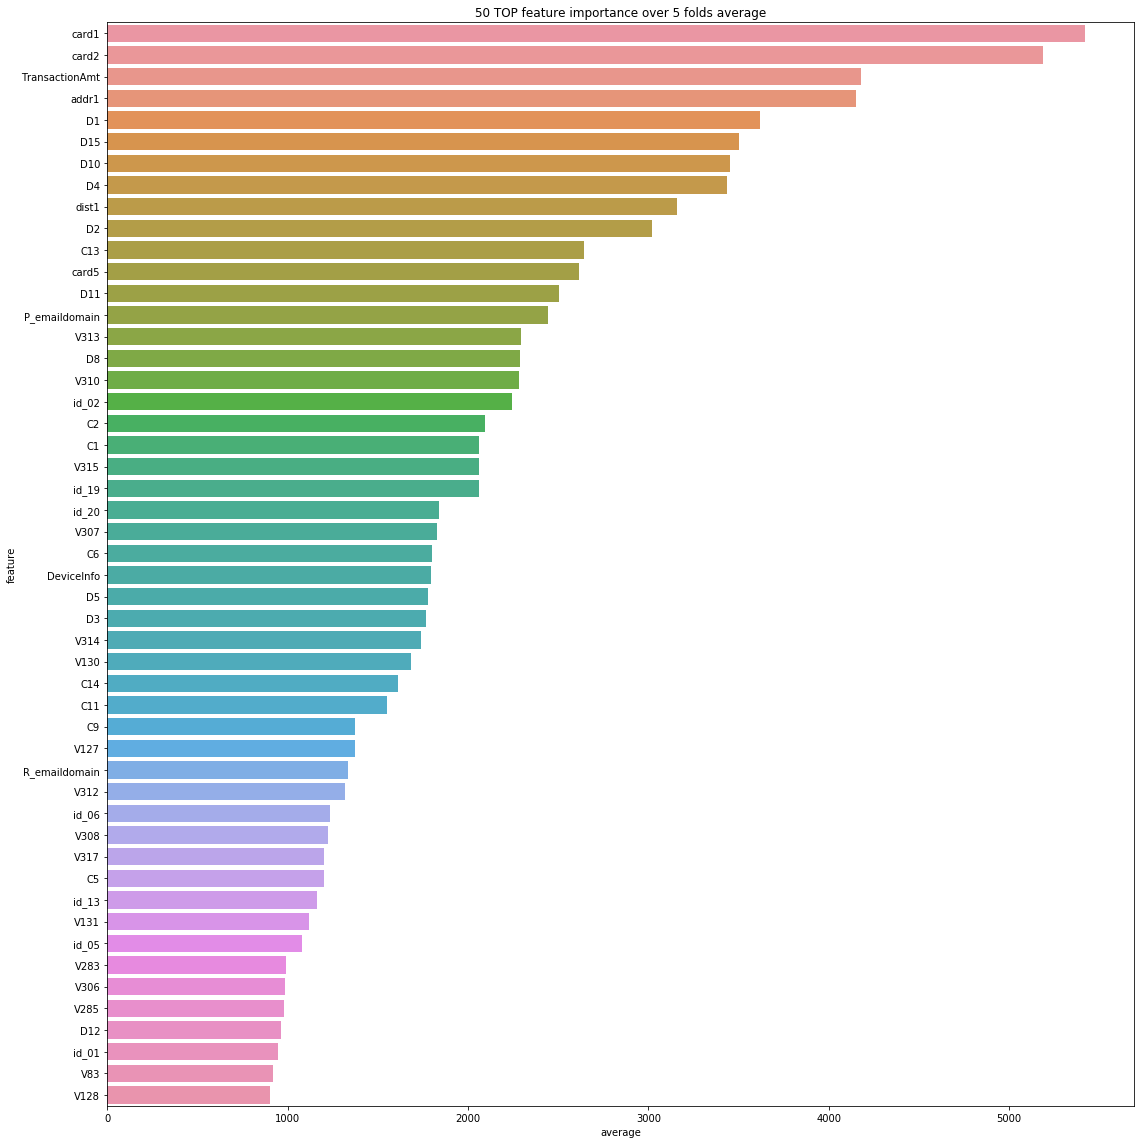

In [380]:
feature_importance['average'] = feature_importance[[f'fold_{i + 1}' for i in range(kf.n_splits)]].mean(axis=1)
# feature_importance.to_csv(f'./outputs/feature_importances_{today}.csv')
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title(f'50 TOP feature importance over {kf.n_splits} folds average')
plt.tight_layout()
plt.savefig(f'./outputs/feature_importances_{today}', dpi=150)
#plt.savefig(f'./outputs/feature_importances_{today}_smirnov05', dpi=150)

## 学習データ全体で再度モデル構築

In [381]:
clf_all = lgb.LGBMClassifier(**params, num_boost_round=clf.best_iteration)
clf_all.fit(X, y)

LGBMClassifier(bagging_fraction=0.3, bagging_seed=11, boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, feature_fraction=0.1,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.01,
        min_data_in_leaf=50, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_boost_round=2473, num_leaves=128,
        objective='binary', random_state=5, reg_alpha=0.3,
        reg_lambda=0.243, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [382]:
submission = sample_sub.copy()
submission['isFraud'] = clf_all.predict_proba(X_test)[:, 1]
submission.to_csv(f'./outputs/LGB_{today}_{score:.4f}.csv', index=False)
#submission.to_csv(f'./outputs/LGB_{today}_{score:.4f}_smirnov05.csv', index=False)

In [105]:
sub1 = pd.read_csv('./outputs/LGB_2019-09-08_0.9161.csv')
submission_ensemble = sample_sub.copy()
fraud = (submission['isFraud'] + sub1['isFraud']) / 2
submission_ensemble['isFraud'] = fraud
submission_ensemble.to_csv(f'./outputs/LGB_ensemble_{today}.csv', index=False)